## Compare the integral time scale of the two gamma models

In [1]:
import sfoda.suntans.sunxarray as sxr

import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map
from tqdm import tqdm


In [2]:
import nonstat_itides_jax as nsjax

import nonstat_itides as nsit

In [3]:
plt.rcParams['font.size']=12
plt.rcParams['axes.labelsize']='small'
plt.rcParams['pcolor.shading']='auto'

In [4]:
# s3login = '/home/mrayson/code/s3.acacia.login'
s3login = '/home/jupyter-mrayson/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)

In [5]:
###
has_gamma = True
paramsfile1 = '../DATA/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_meso_M2S2_vc.nc'
scenario1 = 'seasonaltides_meso_M2S2_vc'

has_gamma = False
paramsfile2 = '../DATA/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_meso_M2S2_gamma_1_0_vc.nc'
scenario2 = 'seasonaltides_meso_M2S2_gamma_1_0_vc'

units='cm s$^{-1}$'
vmax=5.
varname='vc'

In [6]:
ds_params1 = xr.open_dataset(paramsfile1, engine='h5netcdf')
# These need filling in??
ds_params1.suntans.xv=ds_params1.xv.values
ds_params1.suntans.yv=ds_params1.yv.values

ds_params2 = xr.open_dataset(paramsfile2, engine='h5netcdf')
# These need filling in??
ds_params2.suntans.xv=ds_params2.xv.values
ds_params2.suntans.yv=ds_params2.yv.values

ds_params1

Changing the _FillValue from -999999 to 999999
Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:  (Nc: 225368, numsides: 8, params: 9, Nk: 80, time: 8761, Np: 454016)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    z_r      (Nk) float64 ...
Dimensions without coordinates: Nc, numsides, params, Nk, Np
Data variables:
    cells    (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    data     (Nc, params) float64 ...
    dv       (Nc) float64 ...
    dz       (Nk) float64 ...
    nfaces   (Nc) int32 6 6 6 6 6 6 6 6 6 6 6 6 6 ... 6 6 6 6 6 6 6 6 6 6 6 6 6
    xp       (Np) float64 125.2 114.2 136.3 125.4 ... 117.0 117.0 117.1 117.1
    xv       (Nc) float64 109.0 109.1 109.1 109.2 ... 117.7 117.7 117.7 117.9
    yp       (Np) float64 -14.48 -22.48 -13.24 -14.54 ... -18.27 -18.27 -18.26
    yv       (Nc) float64 -19.4 -19.5 -19.61 -19.71 ... -13.1 -13.12 -13.07
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [7]:
# Plot integral timescales
def integral_timescale(covfunc, covparams, tmax=500, N=1000):
    t = np.linspace(0, tmax, N) # days

    acf = covfunc(t, t[0], covparams)
    
    return 1./covparams[0]**2 * np.trapz(acf, t)


tau_M2 = ds_params1['data'].isel(params=5).values
gamma_M2 = ds_params1['data'].isel(params=7).values
    
T_M2 = np.zeros_like(tau_M2)

acf = nsjax.gamma_exp_1d

for ii in tqdm(range(T_M2.shape[0])):
    T_M2[ii] =  integral_timescale(acf, (1, tau_M2[ii], gamma_M2[ii]), tmax=500, N=1000)


100%|██████████| 225368/225368 [00:54<00:00, 4109.81it/s]


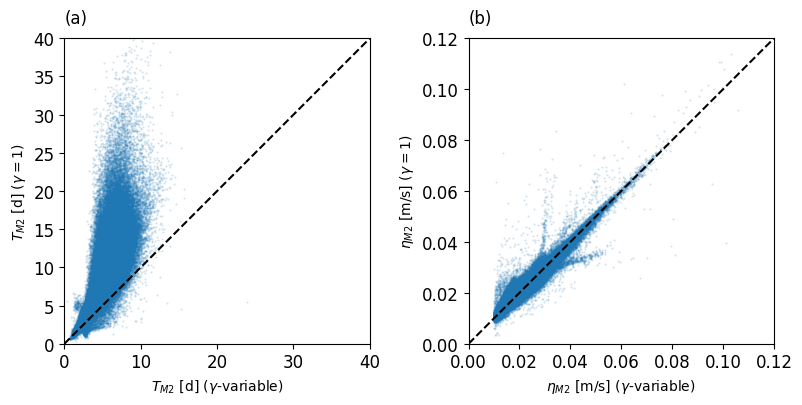

In [11]:
eta_M = ds_params1['data'].isel(params=0).values
eta_M2 = ds_params1['data'].isel(params=3).values

good = (eta_M>0.05) & (eta_M2>0.01)

# Scatter plot of time scale

fig, axs = plt.subplots(1,2, figsize=(8,4))
ax=axs[0]
ax.plot(T_M2[good], ds_params2['data'].isel(params=5).values[good],'.' ,ms=1, alpha=0.2)
ax.plot([0,40],[0,40], 'k--')
ax.set_aspect('equal')
ax.set_xlim(0,40)
ax.set_ylim(0,40)
ax.set_xlabel('$T_{M2}$ [d] ($\gamma$-variable)')
ax.set_ylabel('$T_{M2}$ [d] ($\gamma=1$)')

ax1=axs[1]
ax1.plot(eta_M2[good], ds_params2['data'].isel(params=3).values[good],'.' ,ms=1, alpha=0.2)
ax1.plot([0,0.12],[0,0.12], 'k--')
ax1.set_aspect('equal')
ax1.set_xlim(0,0.12)
ax1.set_ylim(0,0.12)
ax1.set_xlabel('$\eta_{M2}$ [m/s] ($\gamma$-variable)')
ax1.set_ylabel('$\eta_{M2}$ [m/s] ($\gamma=1$)')
ax.text(0.0,1.05, '(a)', transform=ax.transAxes)
ax1.text(0.0,1.05, '(b)', transform=ax1.transAxes)
plt.tight_layout()
plt.savefig('../FIGURES/T_M2_gamma1_vs_T_M2.png', dpi=150)

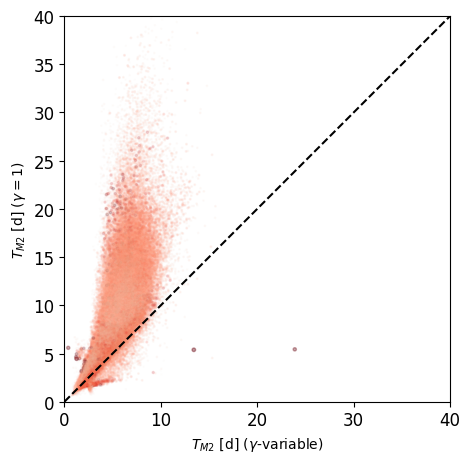

In [10]:
fig, ax = plt.subplots(1,1)

c = eta_M2[good]
ax.scatter(T_M2[good], ds_params2['data'].isel(params=5).values[good],s=c/0.075*3,
          c=c, alpha=c/0.08*0.2,
           cmap='Reds', vmin=0, vmax=0.075)
ax.plot([0,40],[0,40], 'k--')
ax.set_aspect('equal')
ax.set_xlim(0,40)
ax.set_ylim(0,40)
ax.set_xlabel('$T_{M2}$ [d] ($\gamma$-variable)')
ax.set_ylabel('$T_{M2}$ [d] ($\gamma=1$)')

plt.tight_layout()
plt.savefig('../FIGURES/T_M2_gamma1_vs_T_M2_eta.png', dpi=150)

In [11]:
# Regional plots
def plot_contours(ds):
    return ds.suntans.contourf(ds.dv, [200,1000], 
                           colors='k', 
                           linewidths=0.5, 
                           filled=False, colorbar=False)


def add_colorbar(ax, cc, vmin, vmax, titlestr):
    font = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 12,
        }
    #cbaxes = inset_axes(ax, width="30%", height="3%", loc='lower right', bbox_to_anchor=(0, 0.1, 1, 1),
    #                       bbox_transform=ax.transAxes)
    #cb=plt.colorbar(cc, orientation='horizontal', cax=cbaxes)
    cb=plt.colorbar(cc, ax=ax, orientation='horizontal', shrink=0.3, pad=-0.1, )

    cb.set_ticks([vmin,vmax])
    cb.ax.set_title(titlestr, fontdict=font)

    return cb




In [12]:
# Do a spectral plot
from scipy.signal.windows import hann

def plot_site(ds_data, ds_params, xpt, ypt, acffunc, ax, c='k'):
    data_pt = nsit.extract_point(ds_data, xpt, ypt)
    tdays = (data_pt.time-data_pt.time[0]).values.astype(float)/1e9/86400
    dt = tdays[1]-tdays[0]
    params_pt = nsit.extract_point(ds_params, xpt, ypt)
    acf = acffunc(tdays, tdays[0], [ff for ff in params_pt['data'].data])

    #y = data_pt['eta_steric_non_phase_locked']
    #y = data_pt['eta_non_phase_locked']+data_pt['eta_phase_locked']
    y = data_pt['{}_non_phase_locked'.format(varname)]
    #y = data_pt['uc_non_phase_locked']

    #window=None
    window=hann(y.shape[0])
    
    f, I =  nsit.periodogram(y, delta=dt, h=None)
    f, I2 =  nsit.periodogram(y, delta=dt, h=window)
    #f, I2 =  nsit.periodogram(y2, delta=dt)
    f_S, S = nsit.bochner(acf, delta=dt)
    
    ax.semilogy(f, 2*I2, c='b', lw=0.2)
    #plt.semilogy(f, I2, 'b', lw=0.2)
    ax.semilogy(f_S,S,c, ls='--', lw=2)
    ax.set_ylim(1e-7, 1e0)
    ax.set_xlim(1.6, 2.4)
    #plt.xlim(0.1, 6)
    
    ax.set_xlabel('f [cpd]')
    
    #print(np.exp(params_pt['data'][0:4].data))
    #print(np.exp(params_pt['data'][-1].data))
    #print(nsit.invlogit(params_pt['data'][4:6].data, scale=2))
    print(params_pt['data'].values)


In [13]:
datafile = ds_params1['data'].attrs['input file']
f = S3Map("uwaoceanprocesses-suntans/"+datafile, s3=s3)
ds_data = xr.open_dataset(f, engine='zarr', chunks={}, consolidated=False)

# These need filling in??
ds_data.suntans.xv=ds_data.xv.values
ds_data.suntans.yv=ds_data.yv.values

ds_data

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:              (Nc: 225368, numsides: 8, Nk: 80, time: 8761,
                          Np: 454016)
Coordinates:
  * time                 (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-0...
    z_r                  (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells                (Nc, numsides) int32 dask.array<chunksize=(2000, 8), meta=np.ndarray>
    dv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    dz                   (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    nfaces               (Nc) int32 dask.array<chunksize=(2000,), meta=np.ndarray>
    vc_non_phase_locked  (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    vc_phase_locked      (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    xp                   (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    yp                   (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

[ 0.08978078  5.72672939  1.07153451  0.03290421  0.02303765 10.83850956
 11.89414787  1.27929544  1.08164167]
[ 0.11009745  9.07490158  1.12453496  0.03436277  0.02232701 17.29844666
 14.49628258]


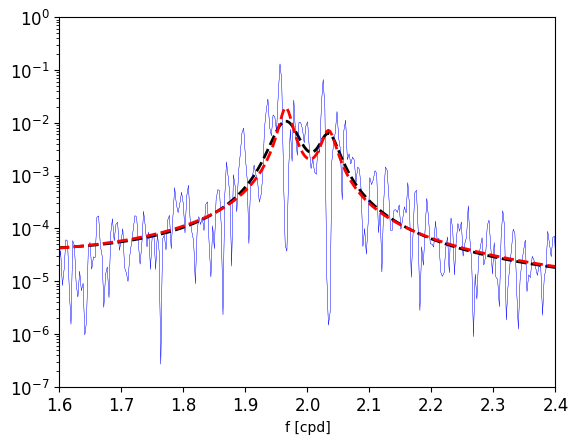

In [14]:
acffunc1 = nsjax.itide_M2S2_meso_gammaexp
acffunc2 = nsjax.itide_M2S2_meso_gammaexp_fixed

xpt, ypt = 122.8,-12.9
plt.figure()
ax=plt.subplot(111)
plot_site(ds_data, ds_params1, xpt, ypt, acffunc1, ax, c='k')
plot_site(ds_data, ds_params2, xpt, ypt, acffunc2, ax, c='r')

[ 0.16784543  7.58056164  1.3374567   0.02799955  0.01170267 10.66391754
  6.35258675  1.65196276  1.17458165]
[1.70688659e-01 8.20453262e+00 1.42682481e+00 3.14935632e-02
 1.12920608e-02 2.56999931e+01 9.89085865e+00]
[ 0.16172618  9.75985146  1.23601544  0.03264425  0.01109011 10.04858112
  7.37043142  1.45516503  1.12441587]
[1.72071323e-01 7.61035824e+00 1.58268595e+00 3.54289338e-02
 1.33581758e-02 2.86987743e+01 1.75530701e+01]
[0.12882705 4.60608292 1.5238241  0.03014039 0.01306051 8.54201221
 7.89498234 1.74575984 0.91428787]
[1.70728922e-01 7.71400070e+00 1.56330991e+00 3.60175706e-02
 1.22230202e-02 2.84188805e+01 1.59715643e+01]
[0.1593937  7.16680956 1.45565915 0.02976282 0.01328891 8.43125248
 8.26288605 1.69374716 1.08092272]
[1.67452231e-01 7.62427711e+00 1.61947870e+00 3.59926783e-02
 1.25762569e-02 2.79870148e+01 1.75902138e+01]
[0.15856829 7.2232151  1.42935634 0.0292547  0.01286221 8.60666466
 7.61127663 1.68065763 1.19190812]
[1.66703910e-01 7.98881912e+00 1.5614732

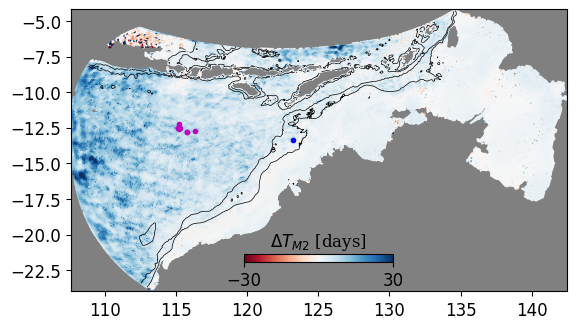

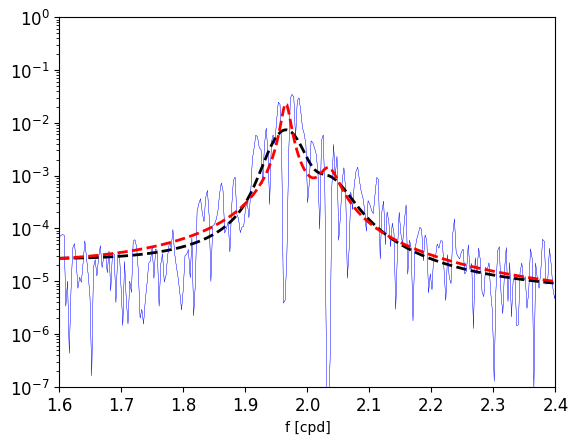

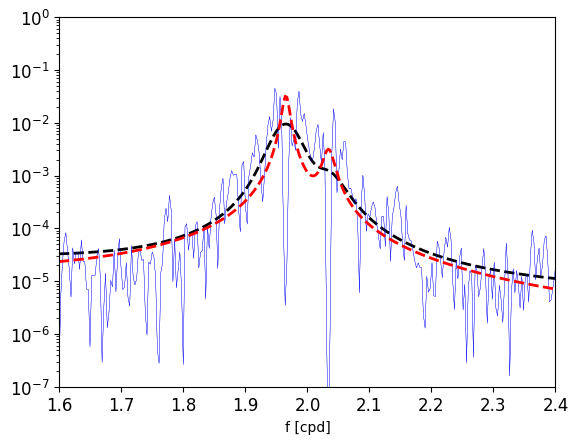

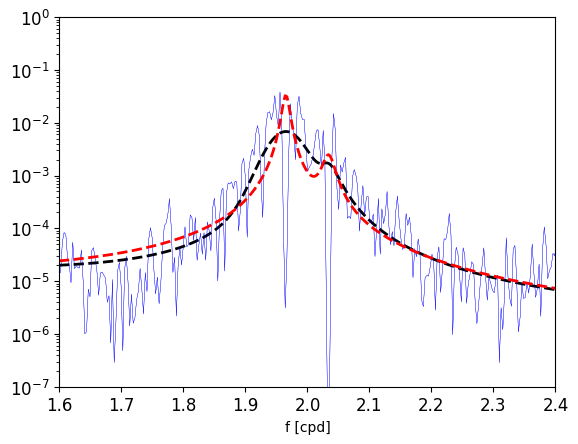

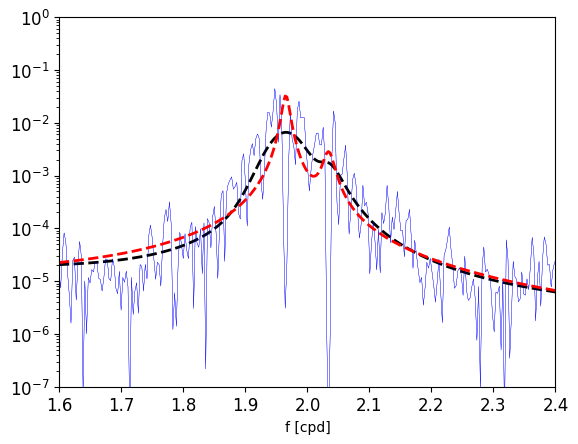

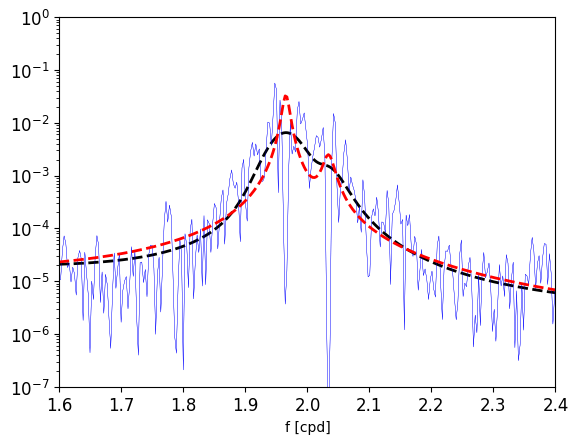

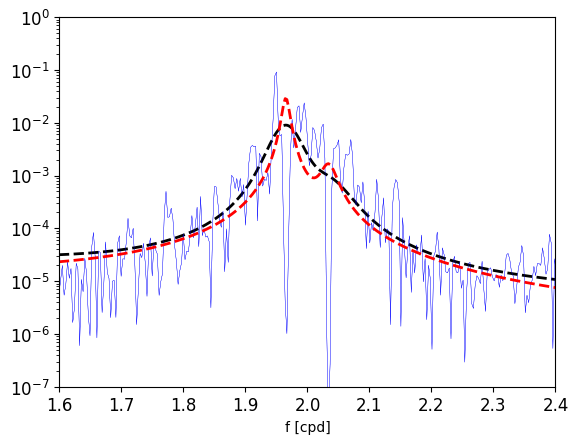

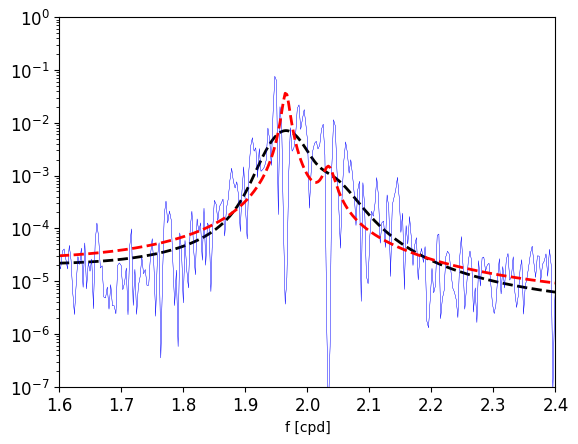

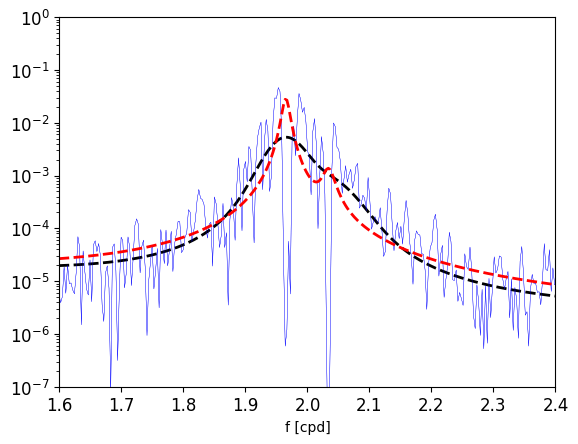

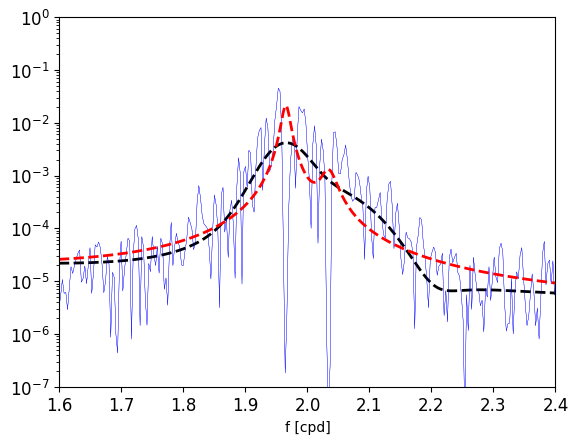

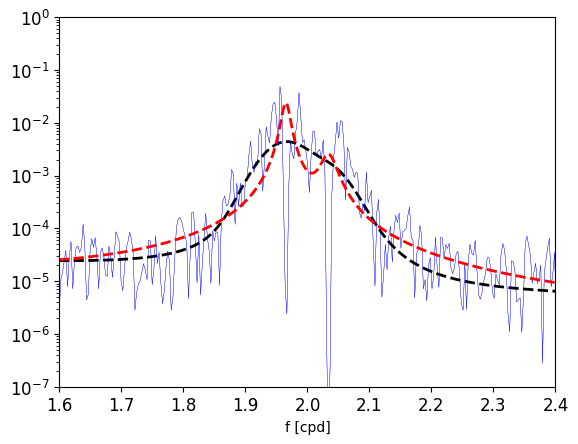

In [19]:
eta = ds_params2['data'].isel(params=3).values
tau = ds_params2['data'].isel(params=5).values

idxs = np.argwhere( (eta>0.03) & (tau>25) )

####
xlim = 112.5, 130
ylim = -23, -8
vmax=30

T_diff = ds_params2['data'].isel(params=5).values - T_M2

ax2=plt.subplot(111, facecolor='0.5')
_,_,cc,_ = ds_params2.suntans.plotcelldata(T_diff, 
                                          colorbar=False, cmap='RdBu', vmin=-vmax, vmax=vmax)
plot_contours(ds_params2)
#plt.title('Incoherent D2 decay time scale [days]')
add_colorbar(ax2, cc, -vmax, vmax, r'$\Delta T_{{M2}}$ [{}]'.format('days'))

# ax2.set_xlim(xlim)
# ax2.set_ylim(ylim)

#ax2.set_yticklabels([])
#ax2.set_xticklabels([])

for idx in idxs[-10::]:
    #print(idx)
    xpt = ds_params2['xv'][idx].values
    ypt = ds_params2['yv'][idx].values
    ax2.plot(xpt, ypt, 'm.')
    plt.figure()
    ax=plt.subplot(111)
    plot_site(ds_data, ds_params1, xpt, ypt, acffunc1, ax, c='k')
    plot_site(ds_data, ds_params2, xpt, ypt, acffunc2, ax, c='r')

xpt, ypt = 123.2,-13.35
ax2.plot(xpt, ypt, 'b.')

[ 0.1020309   9.7807951   0.91716141  0.02809921  0.01856671  6.7475667
 13.13326836  1.7397368   1.22453582]
[ 0.10868705 10.53203583  1.04954743  0.02904875  0.01864847 16.45280266
 17.16510963]


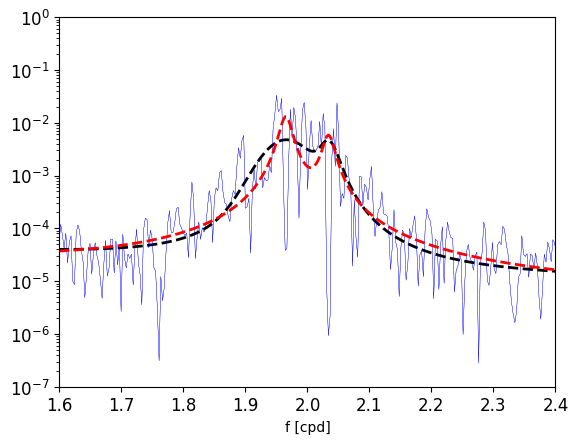

In [34]:
acffunc1 = nsjax.itide_M2S2_meso_gammaexp
acffunc2 = nsjax.itide_M2S2_meso_gammaexp_fixed

plt.figure()
ax=plt.subplot(111)
plot_site(ds_data, ds_params1, xpt, ypt, acffunc1, ax, c='k')
plot_site(ds_data, ds_params2, xpt, ypt, acffunc2, ax, c='r')